C:\Users\owner\AppData\Local\Temp\ipykernel_6108\1984350442.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.FloatTensor(states).to(device)


Episode 500/3000, total_reward=-14.06, eps=0.303
Episode 1000/3000, total_reward=-12.21, eps=0.184
Episode 1500/3000, total_reward=-11.37, eps=0.111
Episode 2000/3000, total_reward=-7.25, eps=0.068
Episode 2500/3000, total_reward=-7.27, eps=0.041
Episode 3000/3000, total_reward=-7.10, eps=0.025


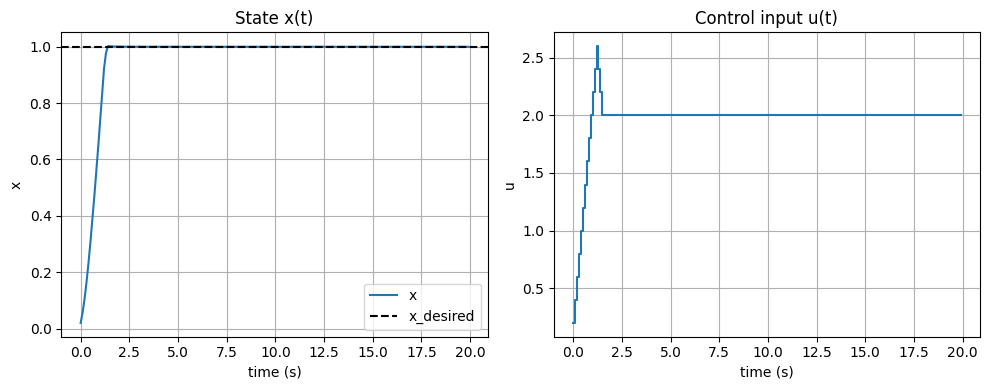

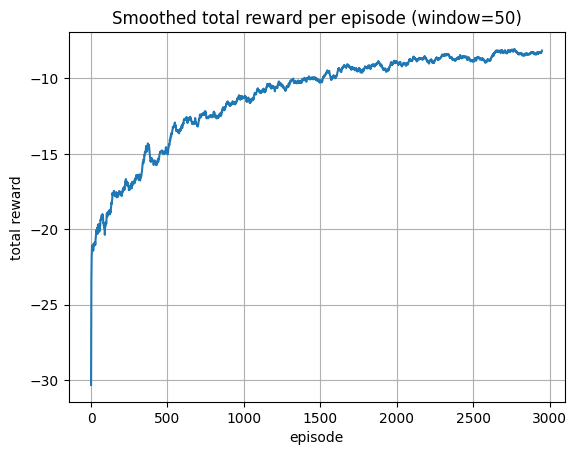

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Environment parameters
dt = 0.1
A = -2.0
x_desired = 1.0
u_min, u_max = -4.0, 4.0
du = 0.2   # control increment

# Number of actions: decrease u, hold, increase u
n_actions = 3
state_dim = 2   #[x, u]


# Neural Network (Q-Network)
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-values
    

# Replay Buffer
memory = deque(maxlen=50000)
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

# Environment step and reward

def env_step(x, u, action):
    if action == 0:
        u = max(u_min, u - du)
    elif action == 2:
        u = min(u_max, u + du)
    x_next = x + dt * (A * x + u)  # Euler step
    return x_next, u

def reward_fn(x, action, act_penalty=0.01):
    return -abs(x - x_desired) - (act_penalty if action != 1 else 0.0)


# Select action (epsilon-greedy)
def select_action(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    else:
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_vals = policy_net(state_t)
        return int(torch.argmax(q_vals, dim=1).item())


# Training step
def train_step(batch_size=64, gamma=0.98):
    if len(memory) < batch_size:
        return
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

    # Q(s,a)
    q_values = policy_net(states).gather(1, actions)

    # Target
    with torch.no_grad():
        q_next = target_net(next_states).max(1, keepdim=True)[0]
        target = rewards + gamma * q_next * (1 - dones)

    loss = nn.MSELoss()(q_values, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = QNetwork(state_dim, n_actions).to(device)
target_net = QNetwork(state_dim, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)

# Training hyperparameters
n_episodes = 3000
max_steps = 200
epsilon = 0.5
epsilon_min = 0.01
epsilon_decay = 0.999
update_target_every = 500  # steps
steps_done = 0


history = []



# Training loop
for ep in range(n_episodes):
    x = np.random.uniform(-0.5, 0.5)
    u = 0.0
    state = np.array([x, u], dtype=np.float32)
    total_r = 0.0

    for t in range(max_steps):
        a = select_action(state, epsilon)
        x_next, u_next = env_step(x, u, a)
        next_state = np.array([x_next, u_next], dtype=np.float32)
        r = reward_fn(x_next, a)

        done = (t == max_steps - 1)
        remember(state, a, r, next_state, done)

        train_step()

        state = next_state
        x, u = x_next, u_next
        total_r += r
        steps_done += 1

        if steps_done % update_target_every == 0:
            target_net.load_state_dict(policy_net.state_dict())

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    history.append(total_r)

    if (ep + 1) % 500 == 0:
        print(f"Episode {ep+1}/{n_episodes}, total_reward={total_r:.2f}, eps={epsilon:.3f}")


def run_episode_greedy():
    x, u = 0.0, 0.0
    traj = []
    for t in range(max_steps):
        state = np.array([x, u], dtype=np.float32)
        a = select_action(state, epsilon=0.0)  # greedy
        x, u = env_step(x, u, a)
        traj.append((t * dt, x, u, a))
    return np.array(traj)

traj = run_episode_greedy()
ts, xs, us, acts = traj[:,0], traj[:,1], traj[:,2], traj[:,3]


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ts, xs, label='x')
plt.axhline(x_desired, color='k', linestyle='--', label='x_desired')
plt.xlabel('time (s)'); plt.ylabel('x'); plt.title('State x(t)'); plt.grid(True); plt.legend()


plt.subplot(1,2,2)
plt.step(ts, us, where='post', label='u (control)')
plt.xlabel('time (s)'); plt.ylabel('u'); plt.title('Control input u(t)'); plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(np.convolve(history, np.ones(50)/50, mode='valid'))
plt.title('Smoothed total reward per episode (window=50)')
plt.xlabel('episode'); plt.ylabel('total reward')
plt.grid(True)
plt.show()
